In [252]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import pi, c
from scipy import signal

ASSUMPTIONS:

- FAR FIELD
- NARROW BAND
- SMALL SCALE

Sample kun på vinduer. Måske også udenfor for at vide noget om støjen.

Støjen skal lægges på som forskellig for radarer, men samme inden for frame

STOP AND HOP: Target flytter sig kun mellem frames! Men i stedet kør hvor den flytter sig mellem chirps! Ikke på chirps, men flytter sig til næste chirp!


Se tidslinjer og sammenlign - 


Skriv første sektion længere - indfør NOVEL vs SOTA algorithms og lidt om det fysiske setup(GT). Ikke specifikke.

# Radar Model - MIMO

In [253]:
# Single Target

target_location = np.array([10, 10]) # Target location on 2-dimensional plane [m]
target_velocity = np.array([5, 5]) # Target velocity in m/s in each dimension [m/s]

In [281]:
# MIMO radar setup

""" TRANSMITTER TXs"""

f_c = 77e9          # start frequency - [Hz]
wavelength = c/f_c  # Lambda wakelength at carrier frequency - [m]

T_c = 25.66e-6      # chirp time/ duration - [s]
bw = 0.77*1e9           # bandwidth eg. from 76. GHz to 77.5 GHz - [Hz]
S = bw/T_c          # chirp rate - [Hz/s]
prf = 1/T_c         # pulse repetition frequency - [Hz]

M = 16             # number of chirps

TX_locations = np.array([-2*wavelength, 0])
                        #[-4*wavelength, 0],
                        #[-6*wavelength, 0]))    # Transmitter location on 2-dimensional plane [m]

                                    # TI har 3 transmitter
                                    # Unilateral antenna array: 1 lambda spacing between antennas


""" RECEIVER RXs"""

fs = 20e6           # sampling frequency - [Hz]
Ns = 16           # number of samples (ADC) - [samples]

RX_locations = np.array(([0, 0],
                        [wavelength/2, 0]))#,
                        #[2*wavelength/2, 0],
                        #[3*wavelength/2, 0]))  # Receiver location on 2-dimensional plane [m]
    
                                    # TI har 4 receiver
                                    # Unilateral antenna array: 1/2 lambda spacing between antennas

In [282]:
print(f"wavelength: {wavelength} m \n chirp_rate: {S} Hz/s \n prf: {prf} Hz \n TX_locations: {TX_locations} m \n RX_locations: {RX_locations} m")

print(f"range resolution: {c/(2*bw)}")

wavelength: 0.0038934085454545454 m 
 chirp_rate: 30007794232268.12 Hz/s 
 prf: 38971.16134060795 Hz 
 TX_locations: [-0.00778682  0.        ] m 
 RX_locations: [[0.        0.       ]
 [0.0019467 0.       ]] m
range resolution: 0.19467042727272726


In [ ]:
"""Compute all radial distances from the target to the TXs and RXs"""
r_TX = np.linalg.norm(TX_locations - target_location, axis=1)
r_RX = np.linalg.norm(RX_locations - target_location, axis=1)

r_TX, r_RX

(array([14.14764281]), array([14.14213562, 14.14075916]))

In [284]:
"""Compute all radial velocities from the target to the TXs and RXs"""

def compute_radial_velocity(x_target, y_target, x_target_velocity, y_target_velocity, x_base, y_base):
    dx = x_target - x_base
    dy = y_target - y_base
    distance = np.sqrt(dx**2 + dy**2)
    radial_velocity = (dx * x_target_velocity + dy * y_target_velocity) / distance
    return radial_velocity

v_TX = compute_radial_velocity(target_location[0], target_location[1], target_velocity[0], target_velocity[1], TX_locations[0], TX_locations[1])
v_RX = compute_radial_velocity(target_location[0], target_location[1], target_velocity[0], target_velocity[1], RX_locations[:,0], RX_locations[:,1])

v_TX, v_RX


(np.float64(7.0710672763441105), array([7.07106781, 7.07106778]))

In [258]:
""" Compute intermediate frequency (IF) signal frequency for TX-RX pair """

def compute_IF(r_TX, r_RX):
    IF_signal = (S*(r_TX+r_RX))/ c
    return IF_signal

""" Compute the phase shift of the IF signal """

def compute_phase_shift():
    phase_shift = 2*pi*f_c*(2*(v_RX[0]*T_c)/c)
    return phase_shift

""" Compute the phase difference between the TX and RX antenna pairs"""

def compute_phase_diff(r_tx, r_rx):
    phase_diff = (2*pi*(r_tx + r_rx)) / wavelength % (2*pi)
    return phase_diff

In [259]:
# Compute the intermediate frequencies for all TX-RX pairs

IF_signals = np.zeros((len(TX_locations), len(RX_locations)))

for t in range(len(TX_locations)):
    for r in range(len(RX_locations)):
        IF_signals[t, r] = compute_IF(r_TX[t], r_RX[r])

# Compute the phase shift of the IF signal

phase_diff = compute_phase_shift() # rad

# Comput the phase difference between the TX and RX antenna pairs

phase_diff_antennas = np.zeros((len(TX_locations), len(RX_locations)))

for t in range(len(TX_locations)):
    for r in range(len(RX_locations)):
        phase_diff_antennas[t, r] = compute_phase_diff(r_TX[t], r_RX[r])
        

print(IF_signals)
print(phase_diff)
print(phase_diff_antennas)

[[2831671.80278636 2831534.02563035 2831396.26188948 2831258.51156766]
 [2832223.25981255 2832085.48265654 2831947.71891567 2831809.96859385]
 [2832774.93091763 2832637.15376162 2832499.39002075 2832361.63969893]]
0.585627605539834
[[0.43885505 4.50070701 2.27958995 0.05868924]
 [3.04662029 0.82528694 4.88735519 2.66645449]
 [5.65783706 3.43650371 1.21538665 5.27767125]]


In [260]:
""" Create all frames for all TX-RX pair IF signals """

times = np.linspace(0, Ns/fs, Ns)

IF_signals_data = {}

for t in range(len(TX_locations)):
    for r in range(len(RX_locations)):
        window = signal.windows.blackman(Ns)
        chirp = np.array(
            [
                (
                    np.exp(1j * (2 * pi * IF_signals[t, r] * times + m * phase_diff + phase_diff_antennas[t, r])) #+ np.random.normal(0, 0.5, Ns)
                )
                * window
                for m in range(M)
            ]
        )
        IF_signals_data[(t, r)] = chirp # Dette er jo egentlig bare en frame

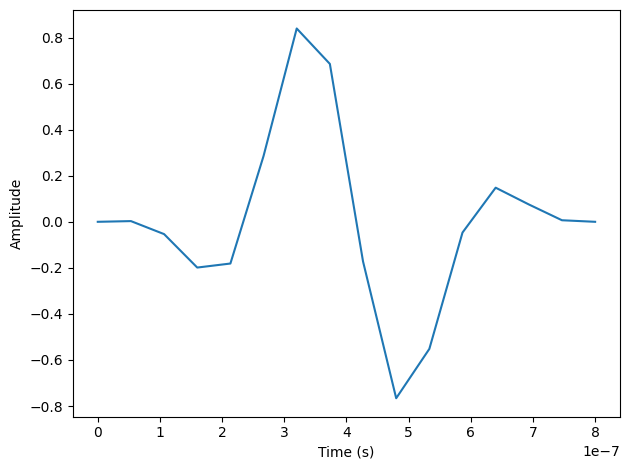

In [261]:

plt.plot(times, IF_signals_data[0,0][0])

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [262]:
""" Range FFT 

max_range = (20e6*c)/(2*S)
max_vel = wavelength / (4 * T_c) # m/s

ranges = np.linspace(0, max_range, Ns)

X_k = np.fft.fft(IF_signals_data[0,0][31])
X_k = np.abs(X_k)
X_k = 10 * np.log10(X_k)

plt.plot(ranges, X_k)
plt.xlabel("Range (m)")

plt.ylabel("Magnitude")
plt.xlim([0, 100])

plt.tight_layout()
plt.show()
"""

' Range FFT \n\nmax_range = (20e6*c)/(2*S)\nmax_vel = wavelength / (4 * T_c) # m/s\n\nranges = np.linspace(0, max_range, Ns)\n\nX_k = np.fft.fft(IF_signals_data[0,0][31])\nX_k = np.abs(X_k)\nX_k = 10 * np.log10(X_k)\n\nplt.plot(ranges, X_k)\nplt.xlabel("Range (m)")\n\nplt.ylabel("Magnitude")\nplt.xlim([0, 100])\n\nplt.tight_layout()\nplt.show()\n'

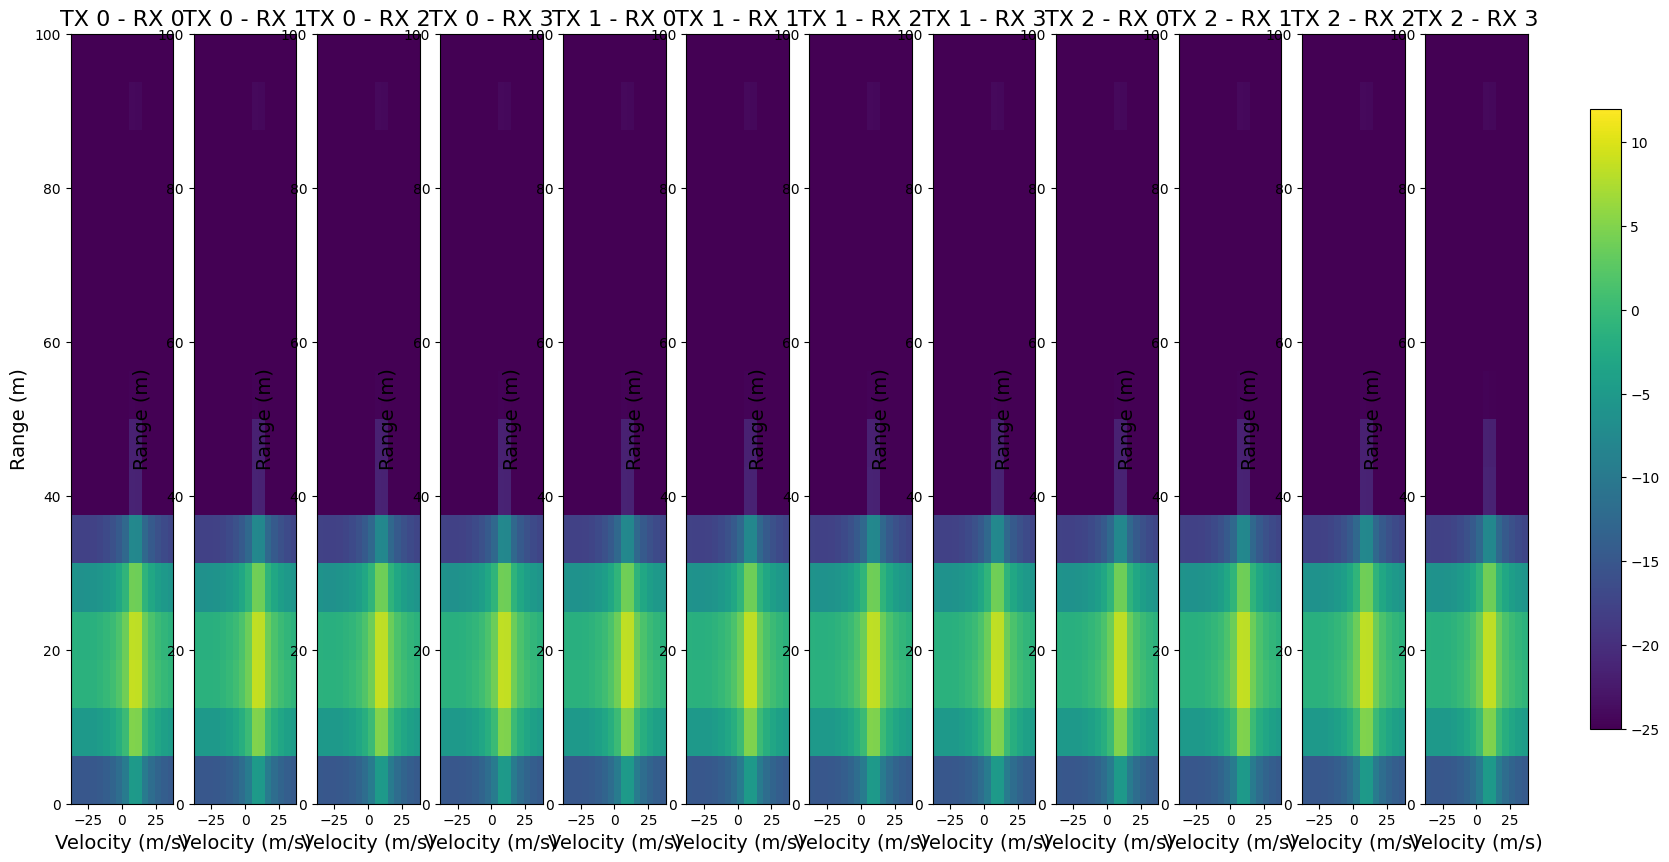

In [263]:
fig, axs = plt.subplots(1, len(IF_signals_data), figsize=(20, 10))

range_doppler_rxs = {}

for idx, (key, chirp) in enumerate(IF_signals_data.items()):
    range_doppler = np.fft.fftshift(np.fft.fft2(chirp.T), axes=1) / (Ns / 2)
    range_doppler_rxs[idx] = range_doppler

    extent = [-max_vel, max_vel, ranges.min(), ranges.max()]

    range_doppler_plot = axs[idx].imshow(
        10 * np.log10(np.abs(range_doppler)),  # np.abs(...): Takes the magnitude, removing the phase.
        aspect="auto",
        extent=extent,
        origin="lower",
        vmax=12,
        vmin=-25,
    )
    axs[idx].set_ylim([0, 100])
    axs[idx].set_xlabel("Velocity (m/s)", fontsize=14)
    axs[idx].set_ylabel("Range (m)", fontsize=14)
    axs[idx].set_title(f"TX {key[0]} - RX {key[1]}", fontsize=16)

fig.colorbar(range_doppler_plot, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()


In [264]:
def extract_phasor(fft_2d):
    """
    Extracts the complex phasor from the 2D FFT peak location.

    Parameters:
    fft_2d : np.array
        2D FFT output.

    Returns:
    phasor : complex
        Complex phasor at the peak location.
    """

    # Find peak location in FFT
    peak_index = np.unravel_index(np.argmax(np.abs(fft_2d)), fft_2d.shape)
    print(peak_index)

    # Extract phasor at the peak position
    phasor = fft_2d[peak_index]

    return phasor


phasors = np.array([extract_phasor(range_doppler_rxs[i]) for i in range(len(range_doppler_rxs))])


(np.int64(2), np.int64(9))
(np.int64(2), np.int64(9))
(np.int64(2), np.int64(9))
(np.int64(2), np.int64(9))
(np.int64(2), np.int64(9))
(np.int64(2), np.int64(9))
(np.int64(2), np.int64(9))
(np.int64(2), np.int64(9))
(np.int64(2), np.int64(9))
(np.int64(2), np.int64(9))
(np.int64(2), np.int64(9))
(np.int64(2), np.int64(9))


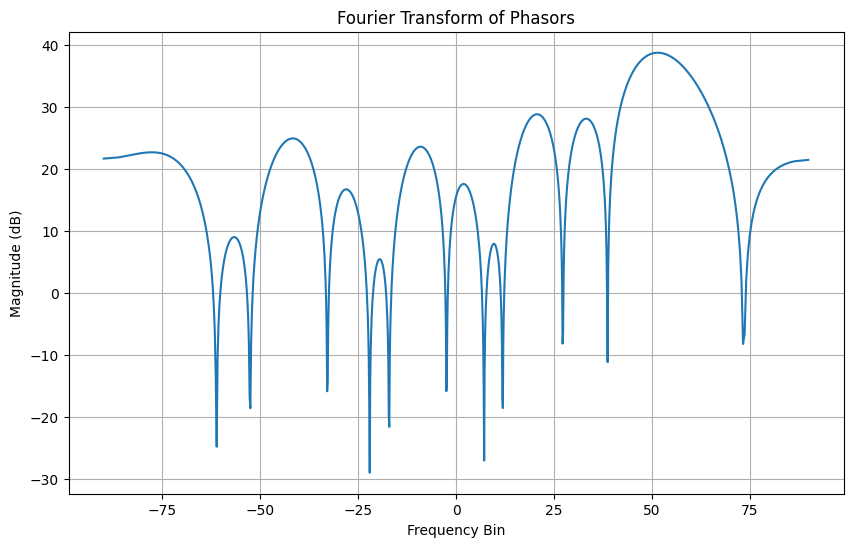

np.float64(51.60833263814753)

In [265]:
# Perform Fourier transform on the phasors

# Zero pad fourier transform
phasors_zero_padded = np.pad(phasors, (0, 1000-len(phasors)), mode='constant')
phasors_fft = np.fft.fftshift(np.fft.fft(phasors_zero_padded))
phasors_fft_magnitude = np.abs(phasors_fft)
phasors_fft_db = 20 * np.log10(phasors_fft_magnitude)

anglebins = np.arcsin(np.linspace(1, -1, 1000))*180/pi

#angle_fft_x = np.linspace(-90, 90, 200)

# Plot the Fourier transform of the phasors
plt.figure(figsize=(10, 6))
plt.plot(anglebins, phasors_fft_db)
plt.xlabel('Frequency Bin')
plt.ylabel('Magnitude (dB)')
plt.title('Fourier Transform of Phasors')
plt.grid(True)
plt.show()

anglebins[np.argmax(phasors_fft_db)]